### Team members:
- Tharun Prabhakar
- Mohammad Zubair Khan
- Niranjan Kumar Kishore Kumar

## Midterm Project

This is a group project. You can work on your own. You can also be in a team up to 3 members.

In this project, you will solve the Gambler’s problem in Barto and Sutton’s book (Example 4.3) using dynamic programming.

* A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips.
* If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake.
* The game ends when the gambler wins by reaching his goal of $\$100$, or loses by running out of money.
* On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars.
* This problem can be formulated as an undiscounted, episodic, finite MDP. i.e., $\gamma=1$
* The state is the gambler’s capital, s ∈ {1, 2, ..., 99}
* The actions are stakes, a ∈ {0, 1, ..., min(s, 100 − s)}.
* The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1.
* The state-value function then gives the probability of winning from each state.
* A policy is a mapping from levels of capital to stakes.
* The optimal policy maximizes the probability of reaching the goal.
* Let $p_h$ denote the probability of the coin coming up heads. If $p_h$ is known, then the entire problem is known and it can be solved.

Your tasks:

Task 1 (4 pts)

* Solve the Gambler’s problem for $p_h$ = 0.25 and $p_h$ = 0.55 using BOTH value iteration and policy iteration, and then generate figures similar to Figure 4.3 in Barto and Sutton’s book.
* In programming, you may find it convenient to introduce two dummy states corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively.
* This task assume $\gamma=1$. Please try other discount factors $\gamma=0.99$ and $\gamma=0.90$ and see how it changes your policy.


Task 2 (6 pts)

* Let's make some changes of this gambling.
    * In task 1, the actions are stakes, a ∈ {0, 1, ..., min(s, 100 − s)}. In task 2, we change it to a ∈ {0, 1, ..., s} which means the gambler can put the entire large capital on stack, similar to those gamblings in movies.
    * The reward is zero on all transitions except those on which the gambler's total capital $\ge \$100$, then the reward is (the final capital - 99) and the game ends.
    * For example, if the gambler has \$80 and he bets on \\$40 and he wins. So his total capital is \\$120, which makes the reward to be 120-99=21
    * New Rule: when the coin gets head, the head has $1/8$ chance of pointing North. If it happens, the gambler will win double dollars as the stake. In above example, the total capital will become \\$80 +2 $\times$ \\$40 = \\$160 and reward is $61$
    * Intuitively, if the gambler's current capital is close to $\\$99$, he will likely bet big, hoping to make a big win in the final step. Let's check if your optimal policy shows such strategy.
    * Solve the Gambler’s problem for $p_h$ = 0.25 and $p_h$ = 0.55 using both value iteration and policy iteration, and then generate figures.
    * This task assume $\gamma=1$. Please try other discount factors $\gamma=0.99$ and $\gamma=0.90$ and see how it changes your policy.

Please submit in BOTH ipynb and html formats.

Reference:


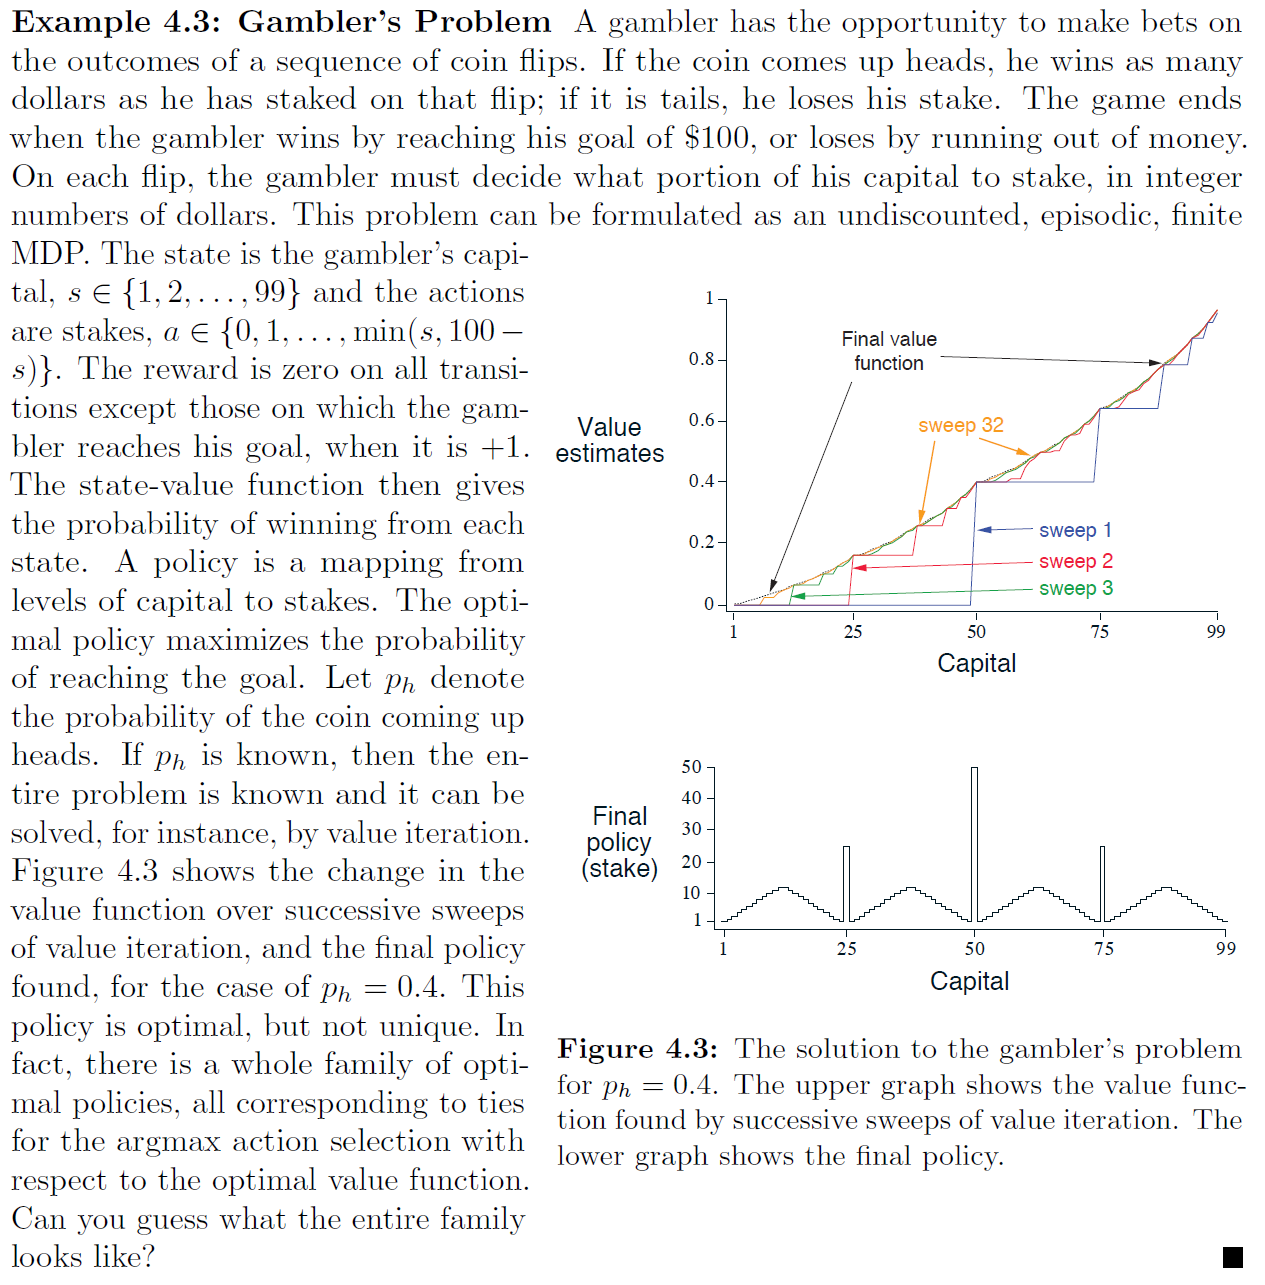

# Defining the environment for Task 1

In [31]:

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

class GamblerEnv:
    def __init__(self, ph=0.4):
        self.ph = ph  # Probability of heads
        self.goal = 100
        self.states = np.arange(self.goal + 1)
        self.terminal_states = [0, self.goal]
        self.observation_space = spaces.Discrete(101)
        self.action_space = spaces.Discrete(101)

    def get_actions(self, state):
        if state in self.terminal_states:
            return [0]
        else:
            return np.arange(1, min(state, self.goal - state) + 1)



# Value iteration using dynamic programing

$$\large  V^{k+1}(s) = \max_{a \in \mathcal{A}} \left\{ r(s, a) + \gamma \sum_{s' \in \mathcal{S}}{} p(s'|s, a)V^k(s')\right\}$$

* Then we will get the optimal policy by

$$\large  \pi(s) =\arg \max_{a \in \mathcal{A}} \left\{ r(s, a) + \gamma \sum_{s' \in \mathcal{S}}{} p(s'|s, a)V^{k+1}(s')\right\}$$

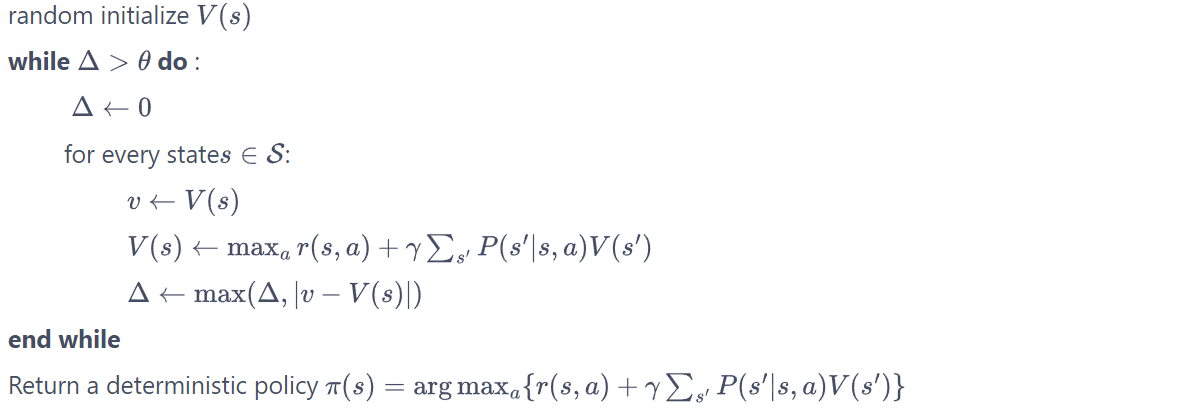

In [50]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: GamblerEnv environment, does not require pre-built P.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all actions in a given state.
        """
        max_stake = min(state, 100 - state)
        A = np.zeros(max_stake + 1)  # Initialize action values

        for a in range(1, max_stake + 1):
            win_state = state + a
            lose_state = state - a
            # Win case
            reward = 1.0 if win_state == 100 else 0.0
            A[a] += env.ph * (reward + discount_factor * V[win_state])
            # Lose case
            A[a] += (1 - env.ph) * (0 + discount_factor * V[lose_state])

        return A

    # Initialize value function
    V = np.zeros(101)  # 101 states (capital from 0 to 100)
    observation_space = spaces.Discrete(101)
    action_space = spaces.Discrete(101)

    while True:
        delta = 0
        # Loop over all states
        for s in range(1, 100):  # Skip terminal states (0 and 100)
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            delta = max(delta, np.abs(best_action_value - V[s]))
            V[s] = best_action_value
        
        # Check if we can stop
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros((101, 101))  # 2D policy matrix [states x actions]
    for s in range(1, 100):  # Skip terminal states
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        policy[s, best_action] = 1.0
    
    return policy, V


# Policy iteration using dynamic programing

* The pseudo code
    * Alternates between evaluating and improving a policy.
    * A policy is a rule that specifies what action to take in each state.
    * The policy iteration algorithm starts with an arbitrary policy, and evaluates its value function by solving a system of equations.
    * Then, it improves the policy by choosing the best action for each state, based on the value function.
    * The policy iteration algorithm converges to the optimal value function and policy, as long as the environment is stationary and fully observable.

    


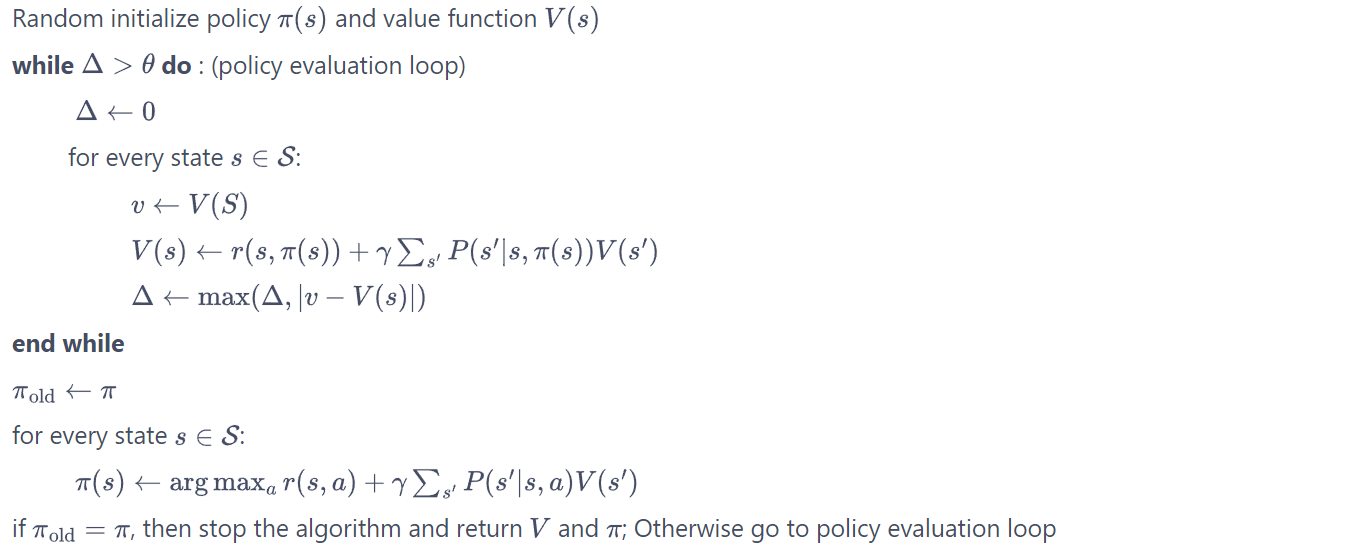

### Note:
For simplicity we have taken policy as one dimensional array that only keeps single stake per capital at a time.

In [51]:
def policy_evaluation(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: The GamblerEnv environment.
        discount_factor: Gamma discount factor.
        theta: Threshold for stopping evaluation once the value function change is below it.
    
    Returns:
        Vector of length env.observation_space.n representing the value function.
    """
    # Initialize value function
    V = np.zeros(101)
    
    while True:
        delta = 0
        # Loop over all states
        for s in range(1, 100):  # Skip terminal states
            v = V[s]
            new_v = 0
            max_stake = min(s, 100 - s)
            # Loop over all actions for this state
            for a in range(1, max_stake + 1):
                action_prob = policy[s, a]
                if action_prob == 0:
                    continue
                win_state = s + a
                lose_state = s - a
                reward = 1.0 if win_state == 100 else 0.0
                new_v += action_prob * (env.ph * (reward + discount_factor * V[win_state]) +
                                        (1 - env.ph) * (0 + discount_factor * V[lose_state]))
            V[s] = new_v
            delta = max(delta, np.abs(v - V[s]))
        # Check for convergence
        if delta < theta:
            break
    return V




def policy_improvement(env, policy_eval_fn, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The GamblerEnv environment.
        policy_eval_fn: Policy Evaluation function that takes policy, env, discount_factor.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all actions in a given state.
        """
        max_stake = min(state, 100 - state)
        A = np.zeros(max_stake + 1)
        for a in range(1, max_stake + 1):
            win_state = state + a
            lose_state = state - a
            reward = 1.0 if win_state == 100 else 0.0
            A[a] += env.ph * (reward + discount_factor * V[win_state])
            A[a] += (1 - env.ph) * (0 + discount_factor * V[lose_state])
        return A

    # Initialize a random policy as a 2D array (states x actions)
    policy = np.zeros((101, 101))
    for s in range(1, 100):  # Skip terminal states
        max_stake = min(s, 100 - s)
        policy[s, 1:max_stake + 1] = 1.0 / max_stake  # Uniform distribution over valid actions
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        policy_stable = True
        
        for s in range(1, 100):  # Skip terminal states
            chosen_a = np.argmax(policy[s])
            # Find the best action by one-step lookahead
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.zeros(101)  # Reset the policy for this state
            policy[s, best_a] = 1.0
        
        # If the policy is stable, we've found an optimal policy
        if policy_stable:
            return policy, V


In [52]:
def plot_results(V, policy, ph, gamma, method):
    """
    Plots the value function and policy (stakes) as subplots.
    
    Args:
        V: The value function array.
        policy: The policy array (states x actions).
        ph: The probability of heads.
        gamma: The discount factor.
        method: The method used (Value Iteration / Policy Iteration).
    """
    # Extract the optimal stake for each state (argmax of policy for each state)
    optimal_stakes = np.argmax(policy, axis=1)

    # Create subplots
    plt.figure(figsize=(14, 6))
    
    # Plot Value Function
    plt.subplot(1, 2, 1)
    plt.plot(V)
    plt.xlabel('Capital')
    plt.ylabel('Value Estimates')
    plt.title(f'Value Function\np_h={ph}, gamma={gamma}, {method}')
    
    # Plot Optimal Policy (Stake)
    plt.subplot(1, 2, 2)
    plt.bar(range(len(optimal_stakes)), optimal_stakes)
    plt.xlabel('Capital')
    plt.ylabel('Final policy (stake)')
    plt.title(f'Policy (Stake)\np_h={ph}, gamma={gamma}, {method}')
    
    plt.tight_layout()
    plt.show()


In [53]:
def run_experiments(ph_values, gamma_values):
  for ph in ph_values:
    env = GamblerEnv(ph=ph)
    for gamma in gamma_values:
        # Value Iteration
        policy_vi, V_vi = value_iteration(env, discount_factor=gamma)
        plot_results(V_vi, policy_vi, ph, gamma, 'Value Iteration')

        # Policy Iteration
        policy_pi, V_pi = policy_improvement(env, policy_eval_fn=policy_evaluation, discount_factor=gamma)
        plot_results(V_pi, policy_pi, ph, gamma, 'Policy Iteration')



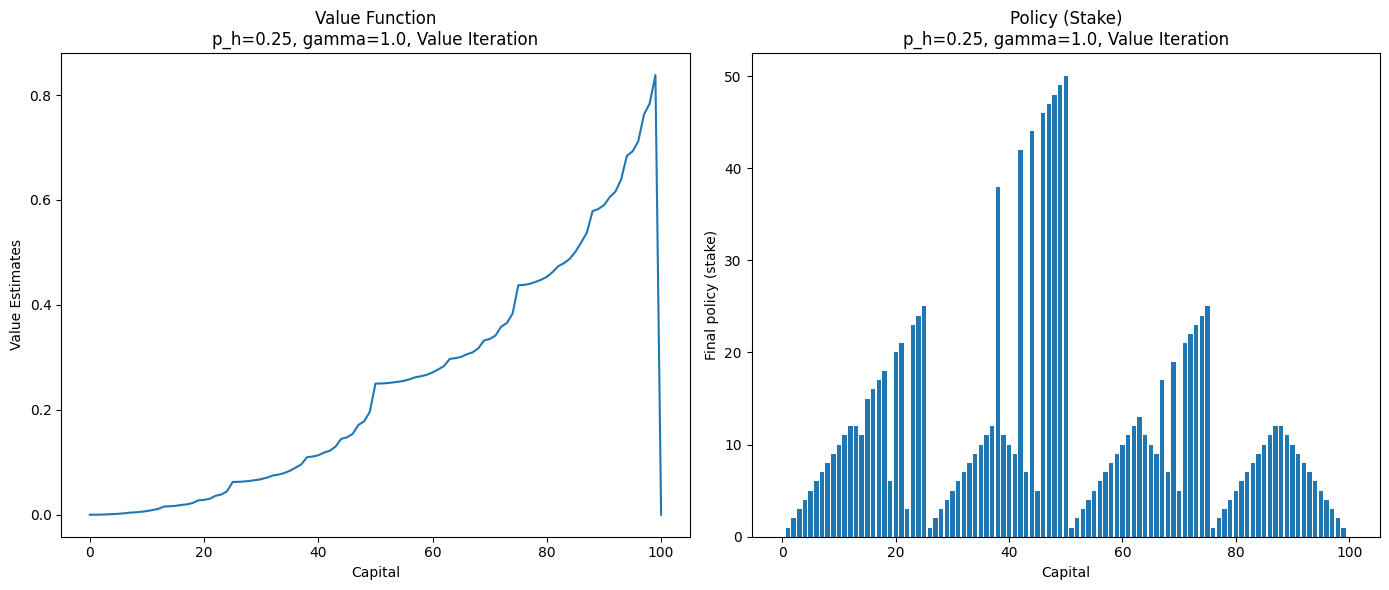

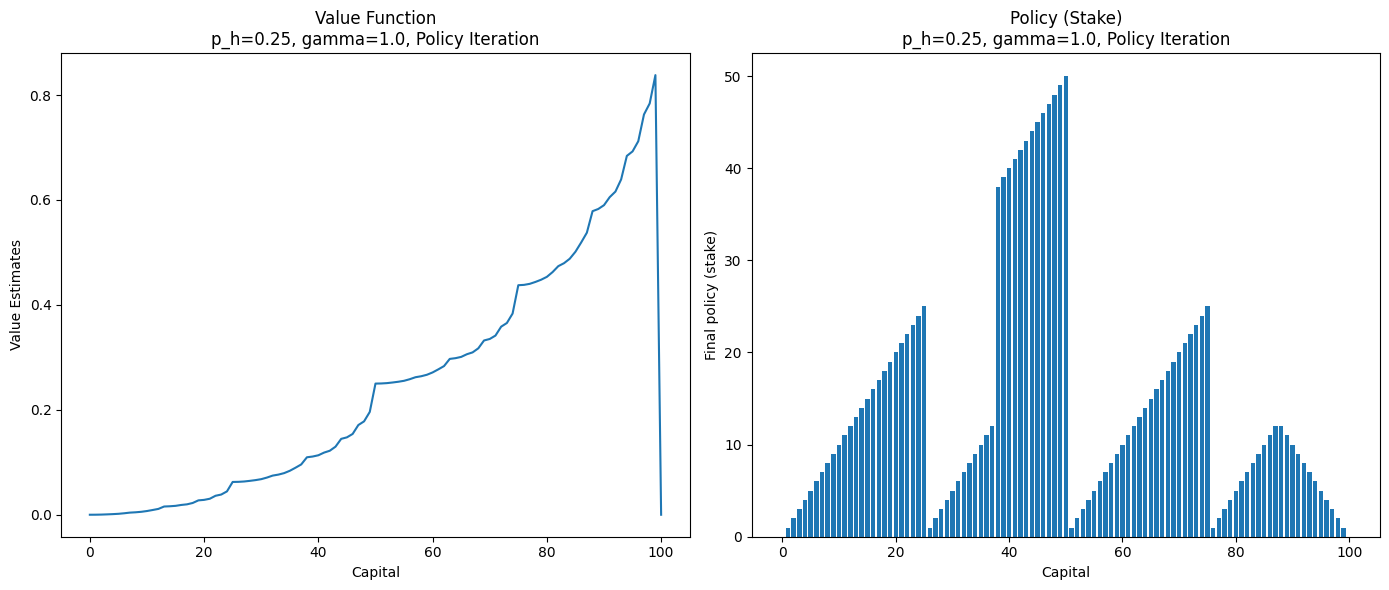

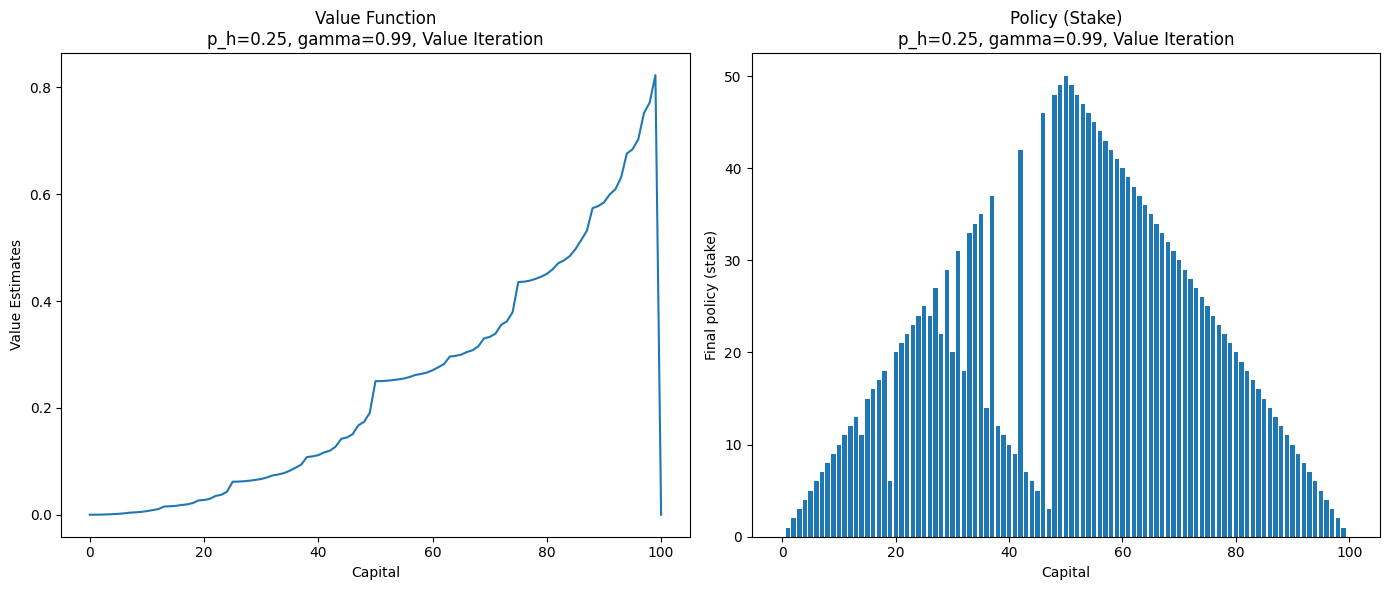

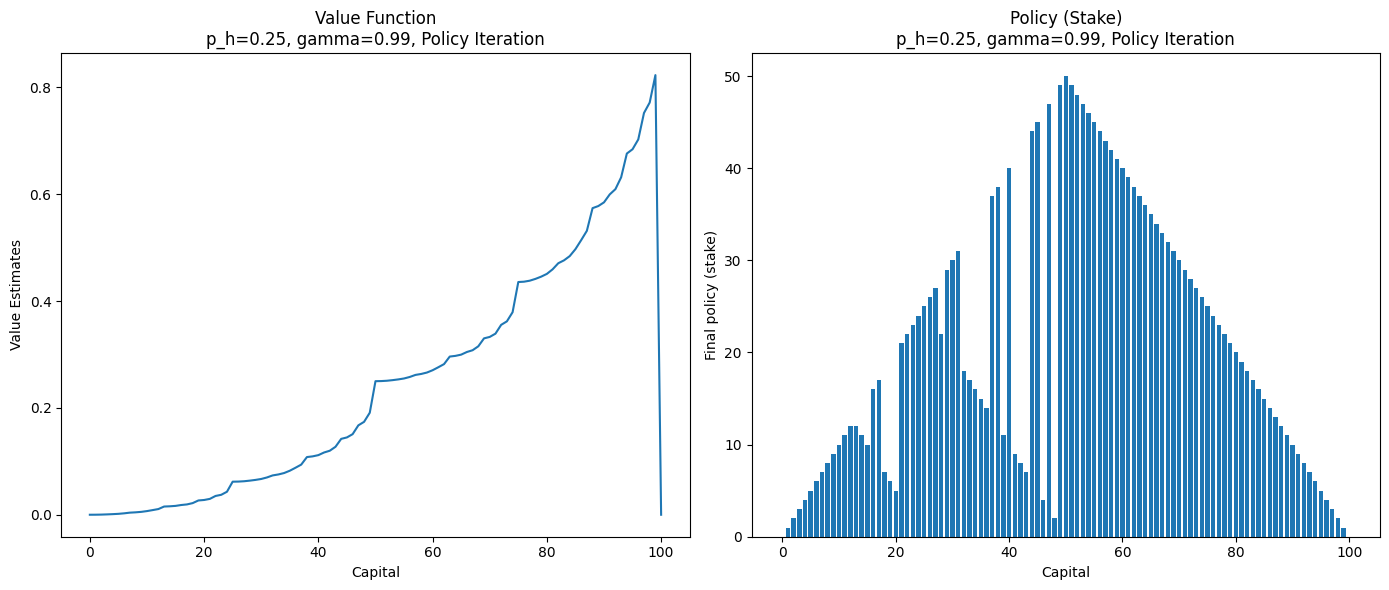

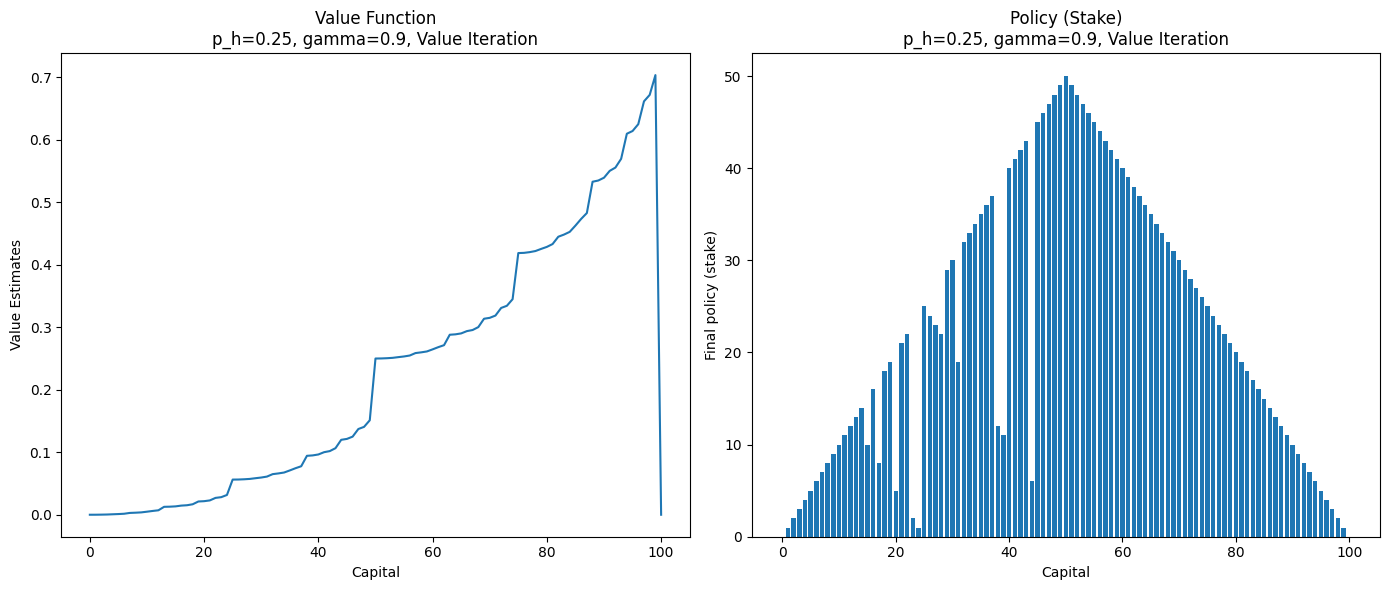

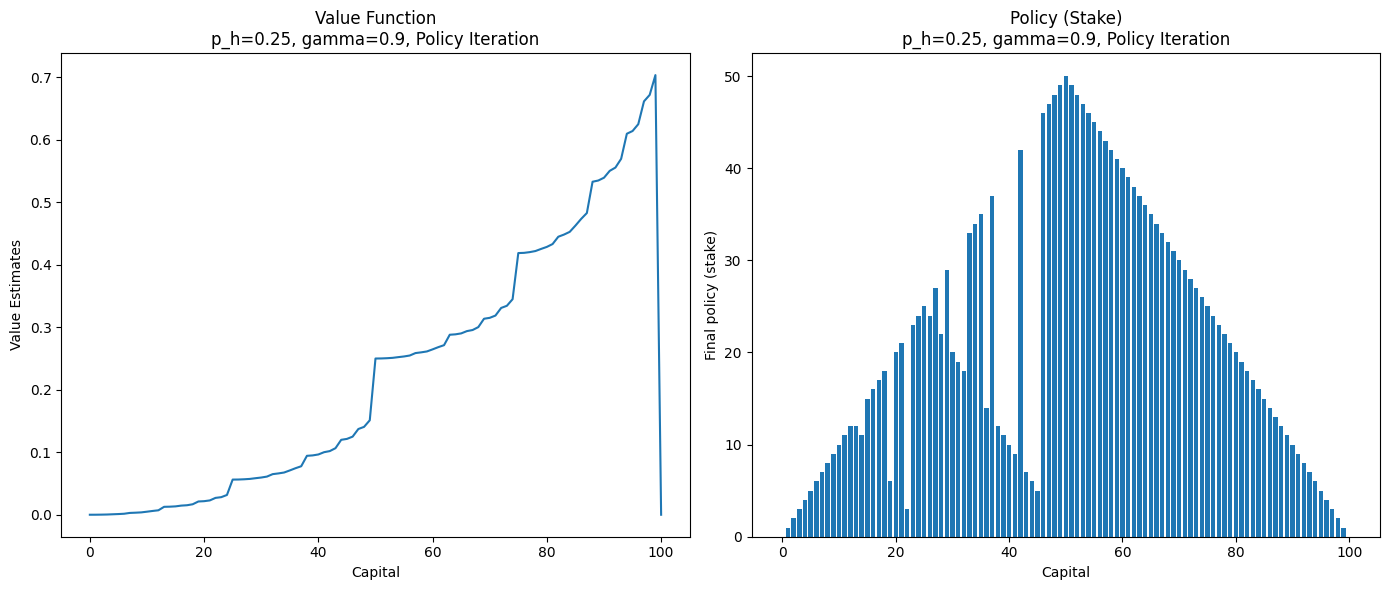

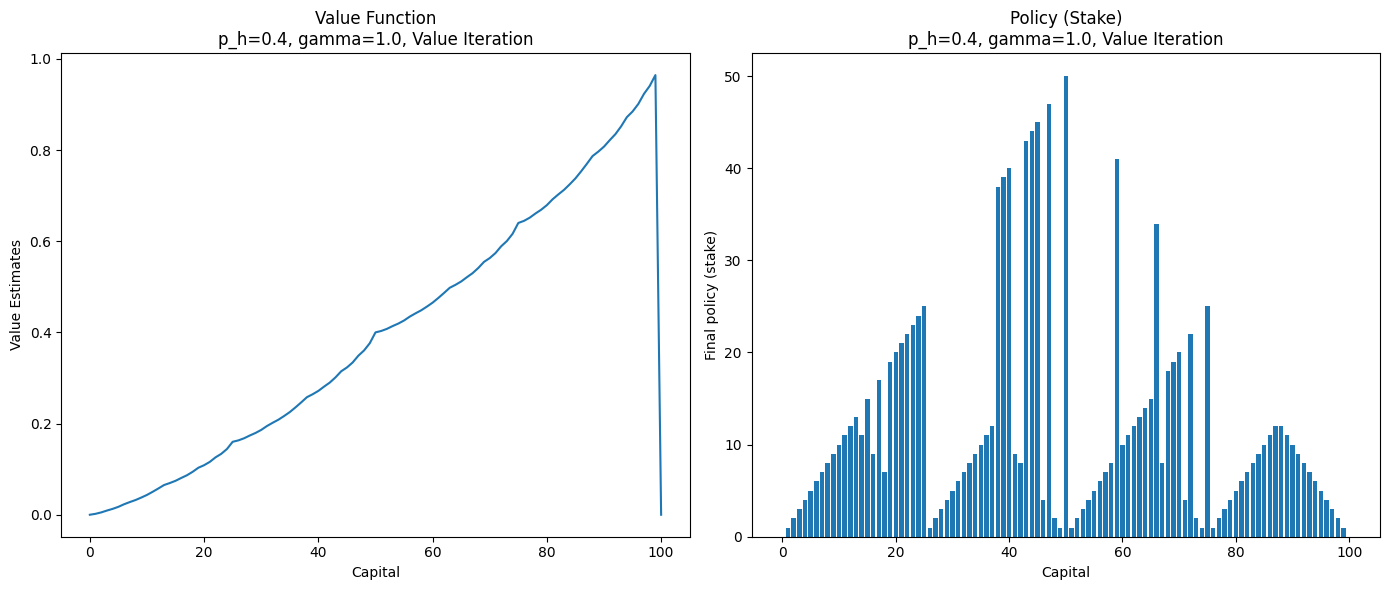

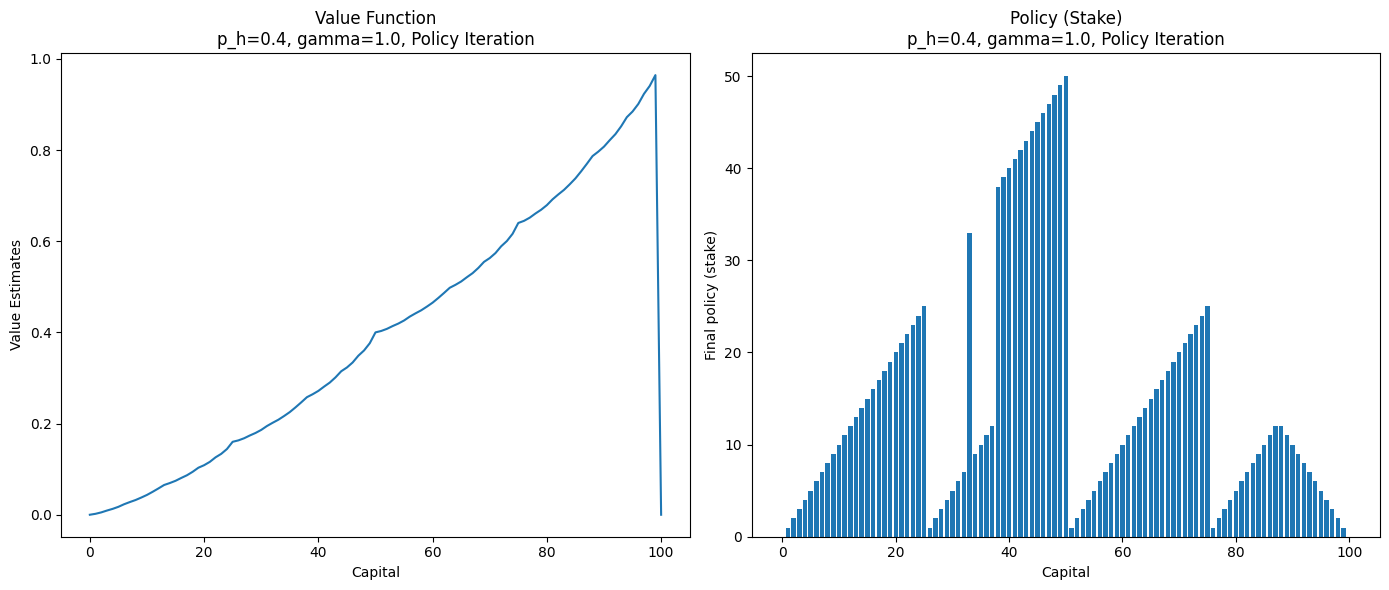

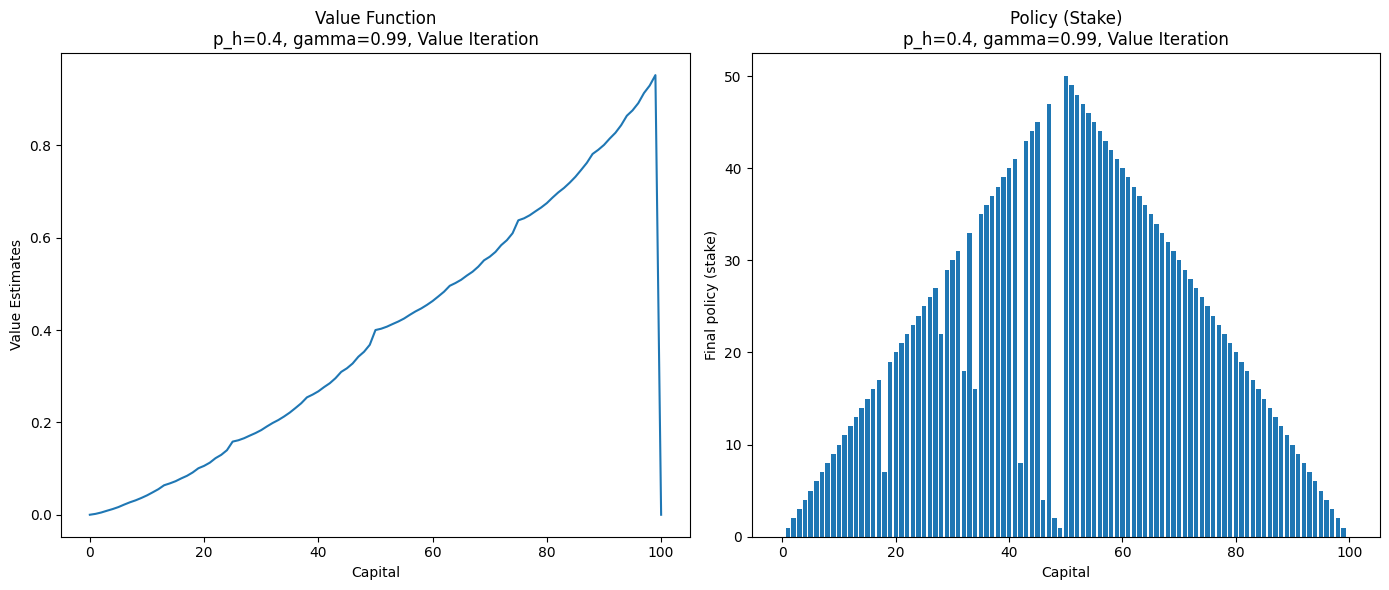

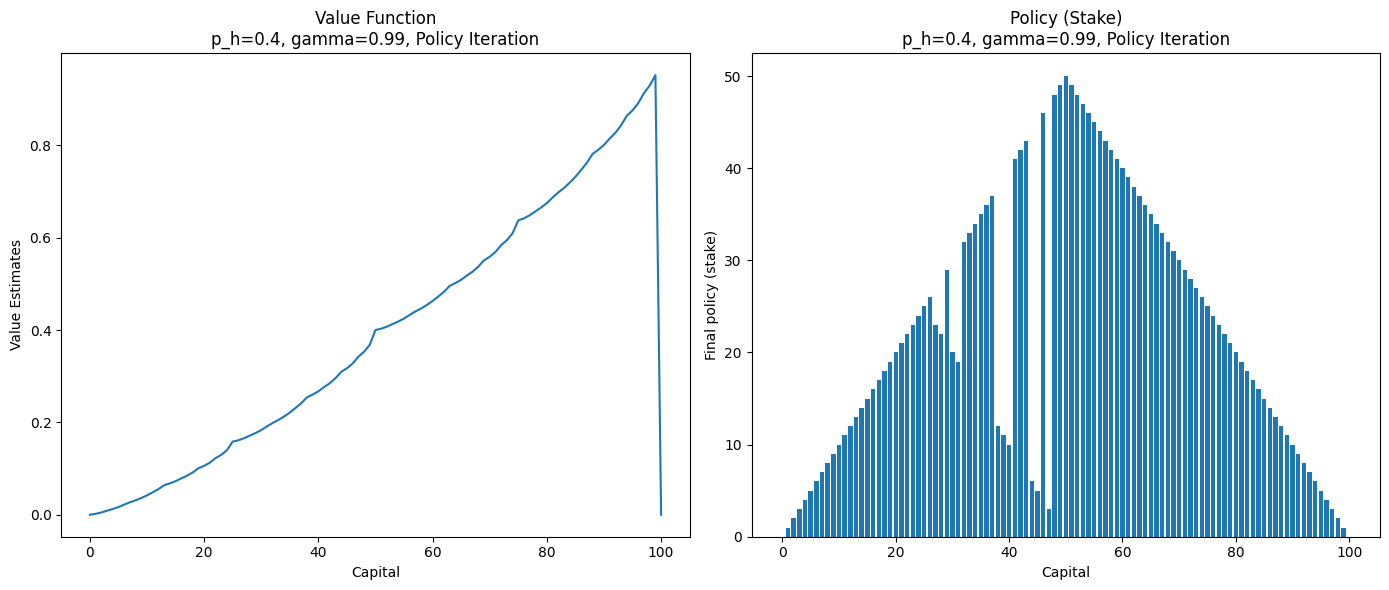

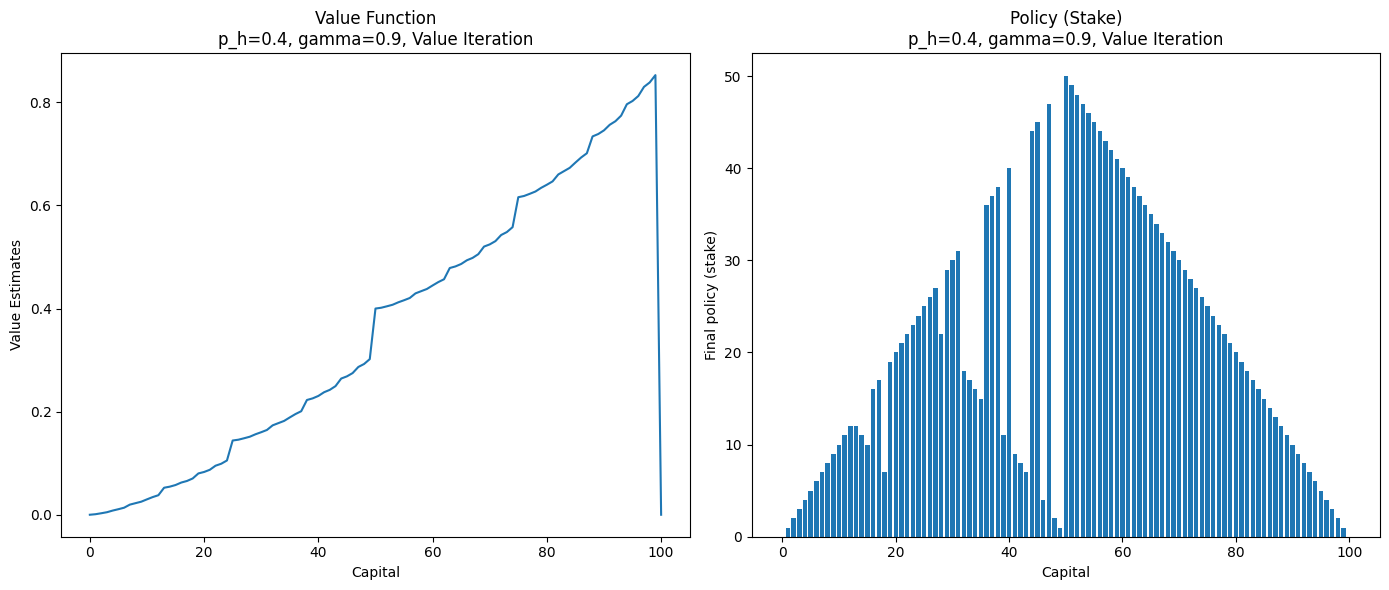

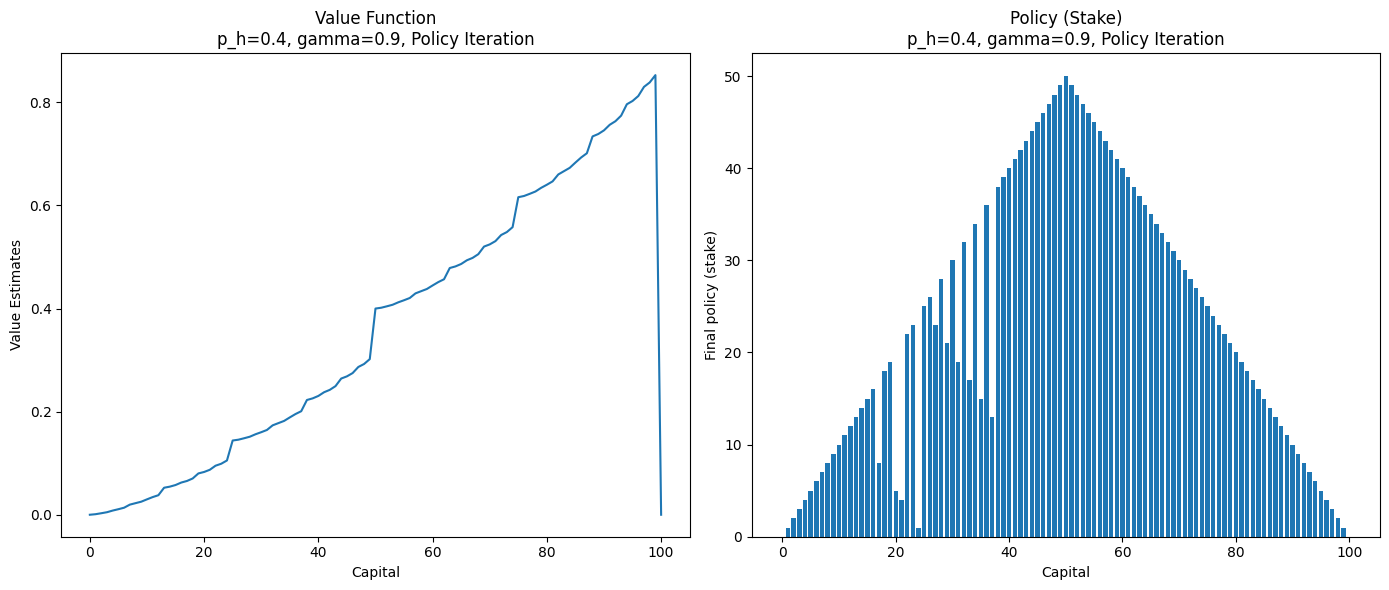

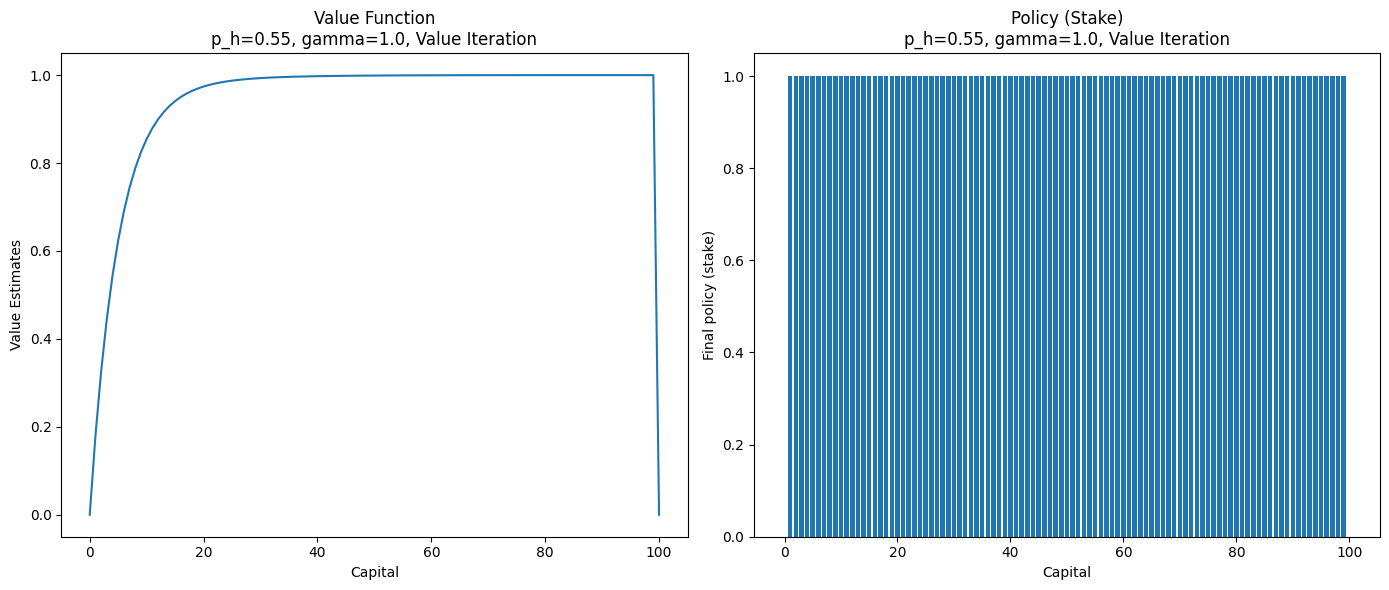

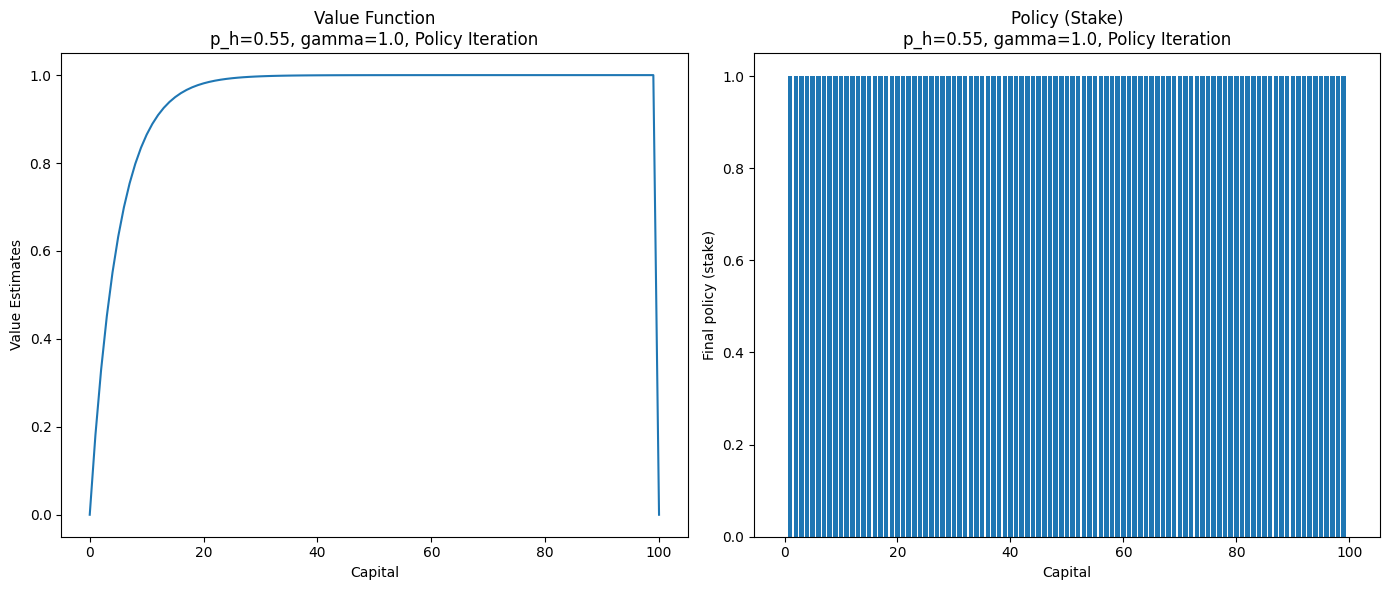

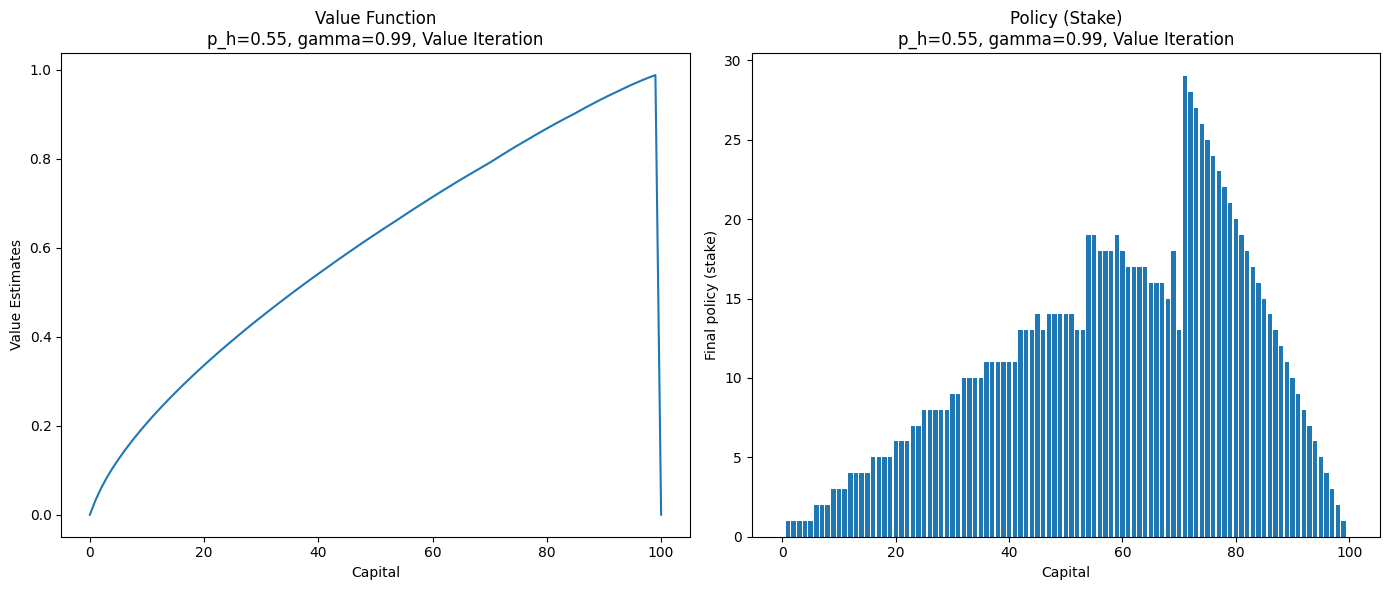

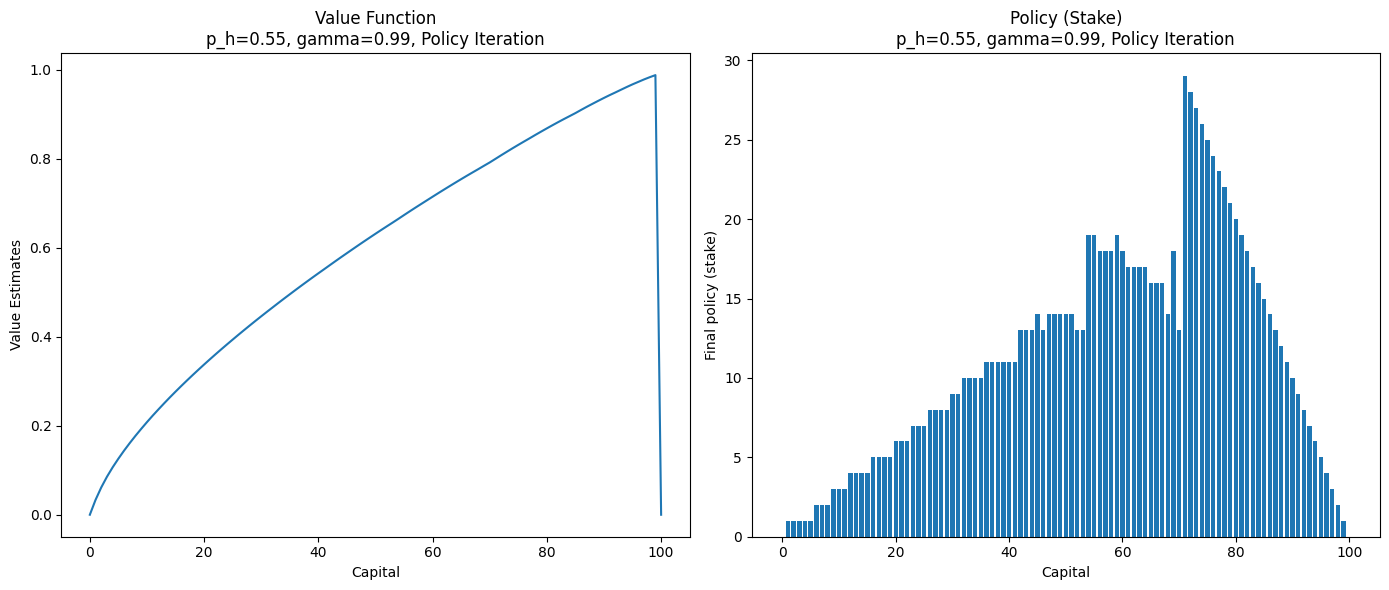

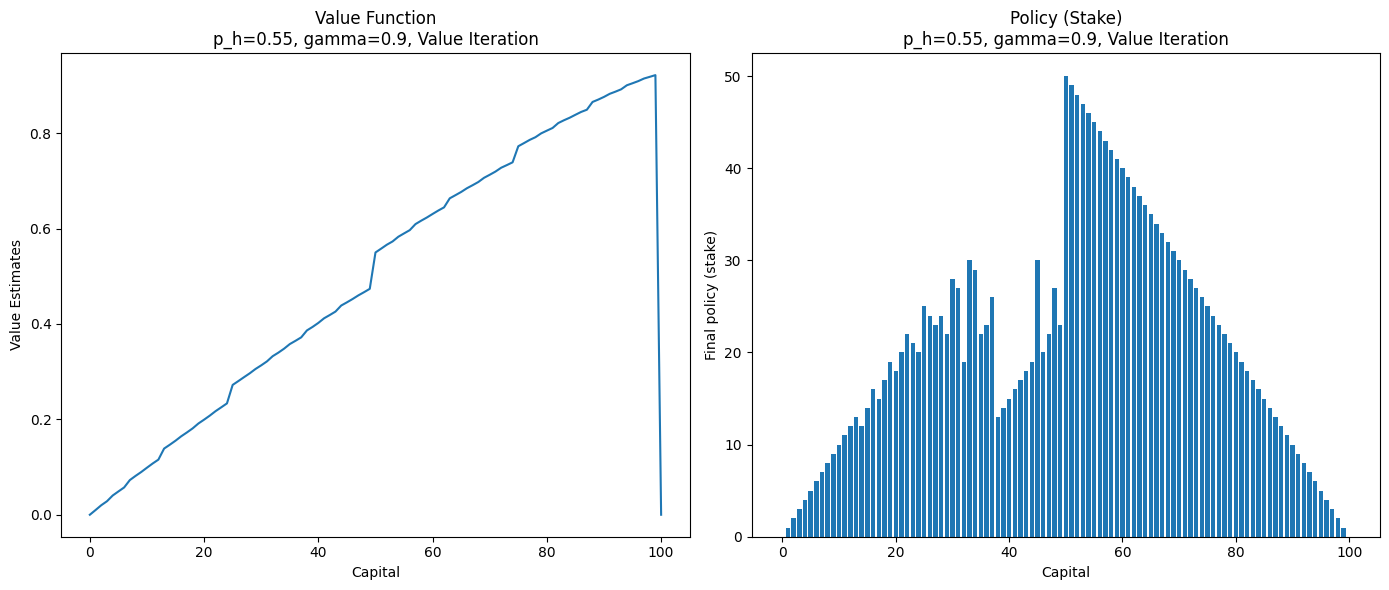

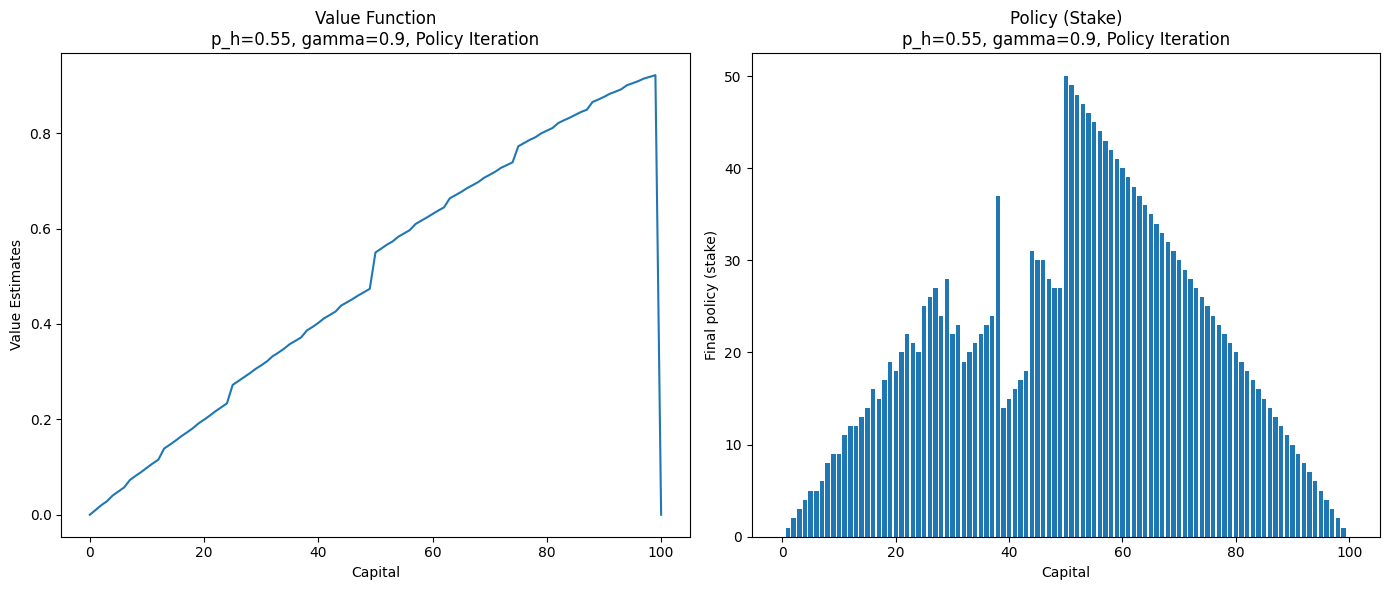

In [54]:
ph_values = [0.25, 0.4,0.55]
gamma_values = [1.0, 0.99, 0.90]
run_experiments(ph_values, gamma_values)


# Defining the environment for Task 2

In [55]:
class ModifiedGamblerEnv:
    def __init__(self, ph=0.4):
        self.ph = ph  # Probability of heads
        self.pn = 1/8  # Probability the coin points North
        self.goal = 100
        self.states = np.arange(self.goal + 1)
        self.terminal_states = [0]

    def get_actions(self, state):
        if state in self.terminal_states:
            return [0]
        else:
            return np.arange(1, state + 1)


# Modified Value iteration

In [56]:
def modified_value_iteration(env, theta=1e-8, gamma=1.0):
    V = np.zeros(env.goal + 1)
    policy = np.zeros((env.goal + 1, env.goal + 1))  # 2D policy [states x actions]
    
    while True:
        delta = 0
        for s in env.states:
            if s in env.terminal_states:
                continue
            actions = env.get_actions(s)
            action_returns = []
            for a in actions:
                a = int(a)
                win_state = s + a
                double_win_state = s + 2 * a
                lose_state = s - a
                win_reward = max(0, win_state - 99) if win_state >= env.goal else 0
                double_win_reward = max(0, double_win_state - 99) if double_win_state >= env.goal else 0
                p_win = env.ph * (1 - env.pn)
                p_double_win = env.ph * env.pn
                p_lose = 1 - env.ph
                action_return = (
                    p_win * (win_reward + gamma * V[int(min(win_state, env.goal))]) +
                    p_double_win * (double_win_reward + gamma * V[int(min(double_win_state, env.goal))]) +
                    p_lose * (0 + gamma * V[int(lose_state)])
                )
                action_returns.append(action_return)
            best_action_value = max(action_returns)
            delta = max(delta, abs(best_action_value - V[s]))
            V[s] = best_action_value
        if delta < theta:
            break
    
    # Derive 2D policy
    for s in env.states:
        if s in env.terminal_states:
            continue
        actions = env.get_actions(s)
        action_returns = []
        for a in actions:
            a = int(a)
            win_state = s + a
            double_win_state = s + 2 * a
            lose_state = s - a
            win_reward = max(0, win_state - 99) if win_state >= env.goal else 0
            double_win_reward = max(0, double_win_state - 99) if double_win_state >= env.goal else 0
            p_win = env.ph * (1 - env.pn)
            p_double_win = env.ph * env.pn
            p_lose = 1 - env.ph
            action_return = (
                p_win * (win_reward + gamma * V[int(min(win_state, env.goal))]) +
                p_double_win * (double_win_reward + gamma * V[int(min(double_win_state, env.goal))]) +
                p_lose * (0 + gamma * V[int(lose_state)])
            )
            action_returns.append(action_return)
        best_action_index = np.argmax(action_returns)
        best_action = actions[best_action_index]
        policy[s, :] = 0  # Reset all actions
        policy[s, best_action] = 1.0  # Set the best action
    return policy, V


# Modified Policy iteration

In [57]:
def modified_policy_iteration(env, gamma=1.0):
    policy = np.zeros((env.goal + 1, env.goal + 1))  # 2D policy [states x actions]
    V = np.zeros(env.goal + 1)
    is_policy_stable = False

    while not is_policy_stable:
        # Policy Evaluation
        while True:
            delta = 0
            for s in env.states:
                if s in env.terminal_states:
                    continue
                a = np.argmax(policy[s])  # Best action for current policy
                if a == 0:
                    continue
                win_state = s + a
                double_win_state = s + 2 * a
                lose_state = s - a
                win_reward = max(0, win_state - 99) if win_state >= env.goal else 0
                double_win_reward = max(0, double_win_state - 99) if double_win_state >= env.goal else 0
                p_win = env.ph * (1 - env.pn)
                p_double_win = env.ph * env.pn
                p_lose = 1 - env.ph
                v = (
                    p_win * (win_reward + gamma * V[int(min(win_state, env.goal))]) +
                    p_double_win * (double_win_reward + gamma * V[int(min(double_win_state, env.goal))]) +
                    p_lose * (0 + gamma * V[int(lose_state)])
                )
                delta = max(delta, abs(v - V[s]))
                V[s] = v
            if delta < 1e-8:
                break
        
        # Policy Improvement
        is_policy_stable = True
        for s in env.states:
            if s in env.terminal_states:
                continue
            old_action = np.argmax(policy[s])
            actions = env.get_actions(s)
            action_returns = []
            for a in actions:
                a = int(a)
                win_state = s + a
                double_win_state = s + 2 * a
                lose_state = s - a
                win_reward = max(0, win_state - 99) if win_state >= env.goal else 0
                double_win_reward = max(0, double_win_state - 99) if double_win_state >= env.goal else 0
                p_win = env.ph * (1 - env.pn)
                p_double_win = env.ph * env.pn
                p_lose = 1 - env.ph
                action_return = (
                    p_win * (win_reward + gamma * V[int(min(win_state, env.goal))]) +
                    p_double_win * (double_win_reward + gamma * V[int(min(double_win_state, env.goal))]) +
                    p_lose * (0 + gamma * V[int(lose_state)])
                )
                action_returns.append(action_return)
            best_action_index = np.argmax(action_returns)
            best_action = actions[best_action_index]
            policy[s, :] = 0  # Reset all actions
            policy[s, best_action] = 1.0  # Set the best action
            if old_action != best_action:
                is_policy_stable = False
    return policy, V


In [58]:
def run_modified_experiments(ph_values, gamma_values):
    for ph in ph_values:
        env = ModifiedGamblerEnv(ph=ph)
        for gamma in gamma_values:
            # Value Iteration
            policy_vi, V_vi = modified_value_iteration(env, gamma=gamma)
            plot_results(V_vi, policy_vi, ph, gamma, 'Value Iteration (Modified)')



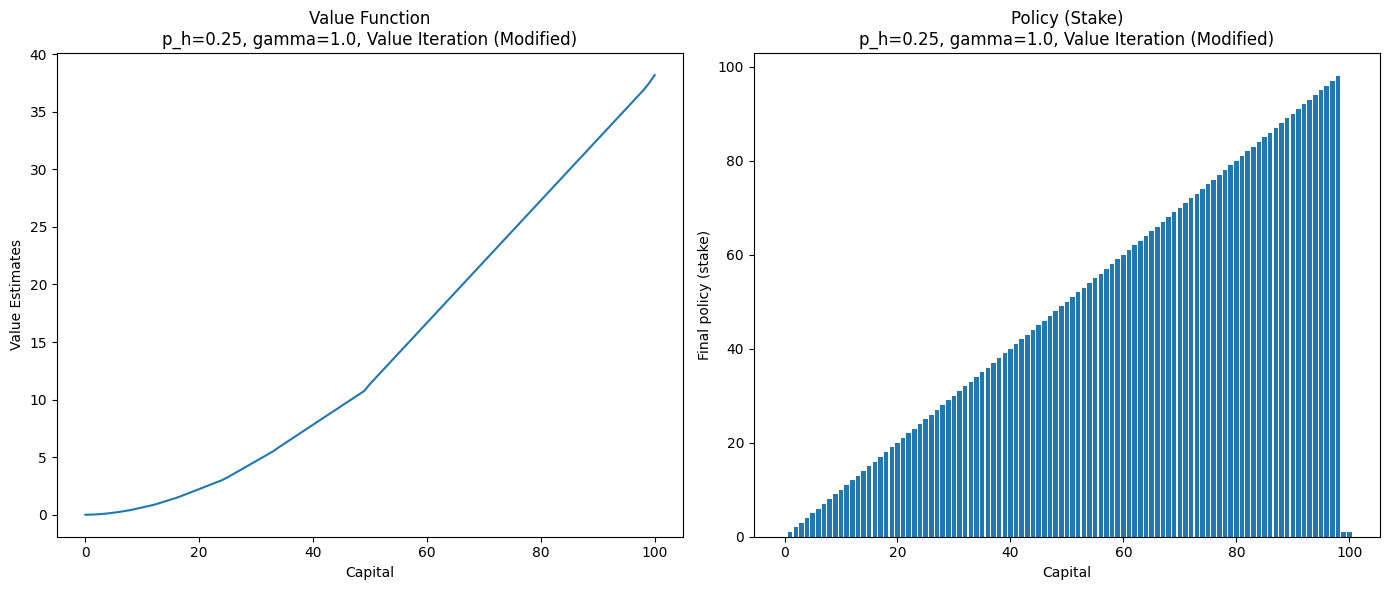

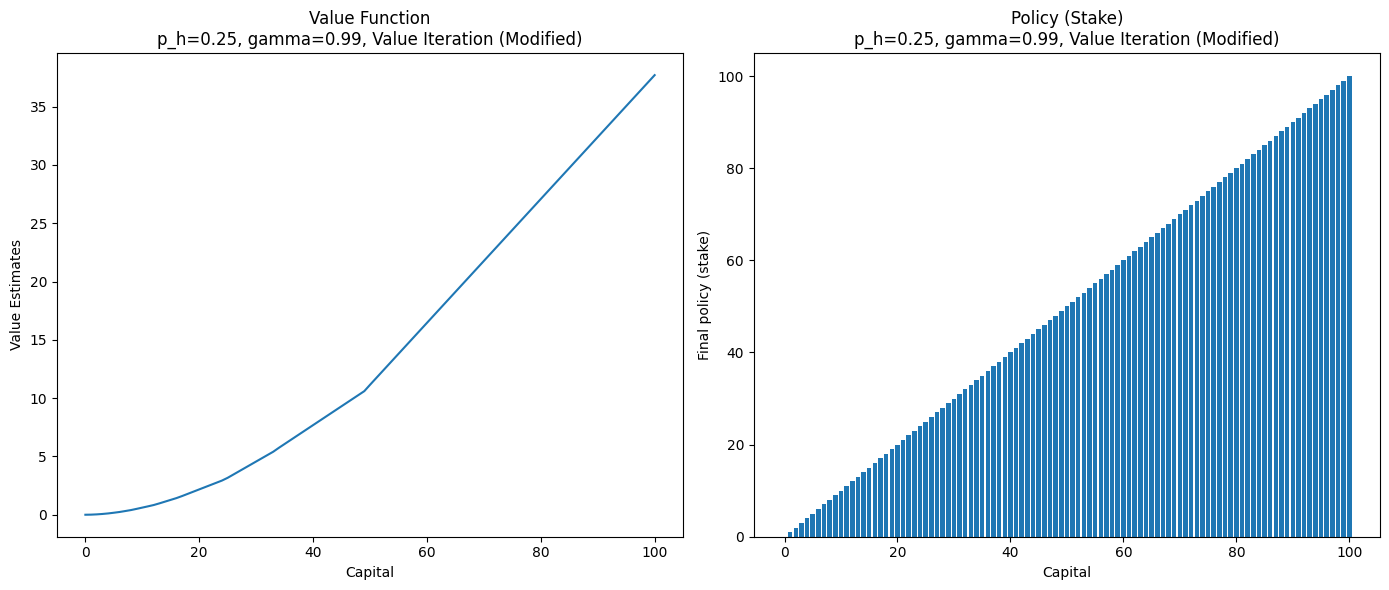

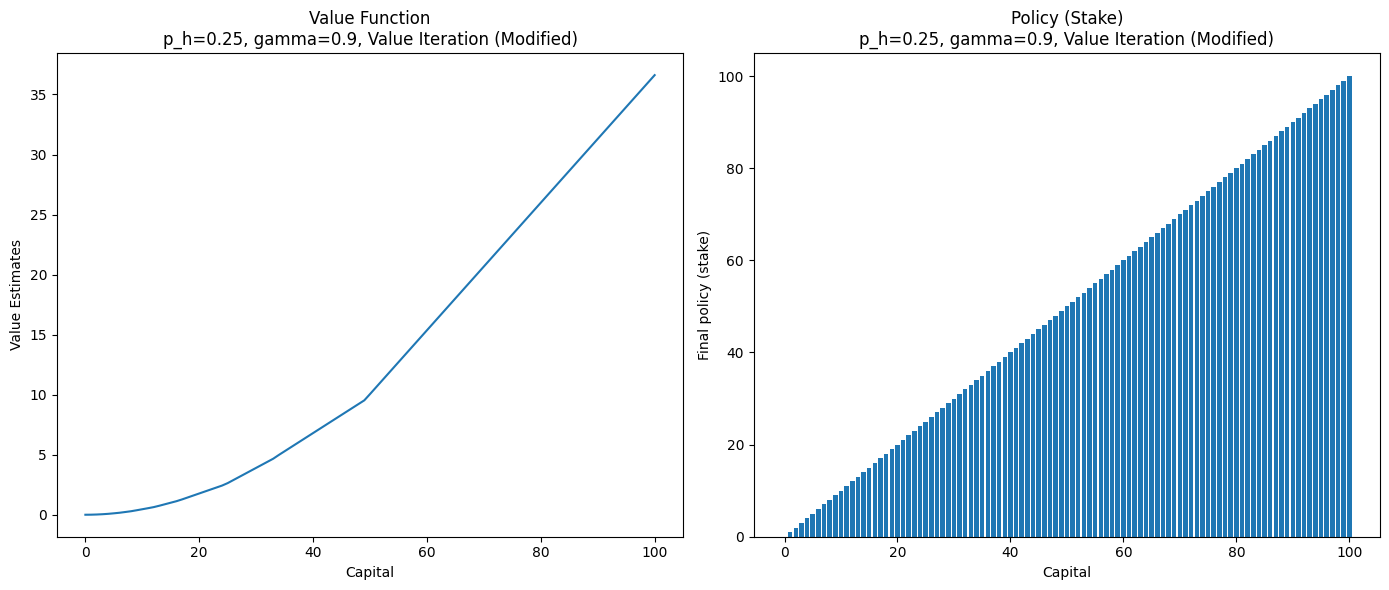

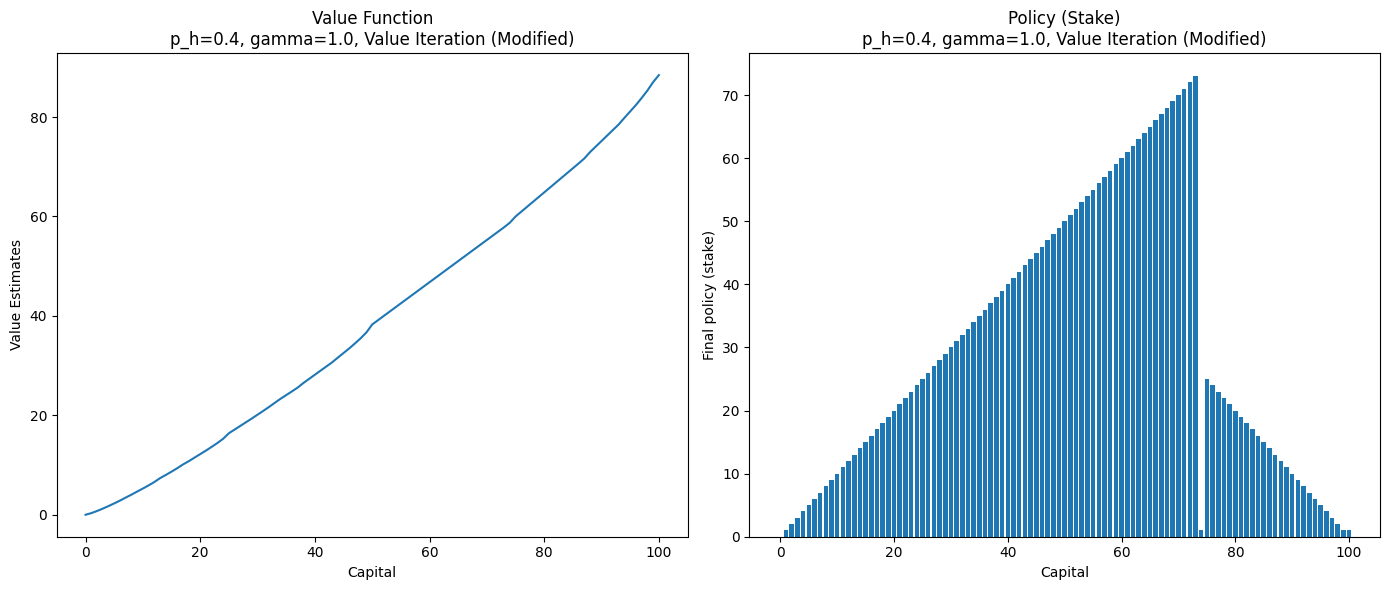

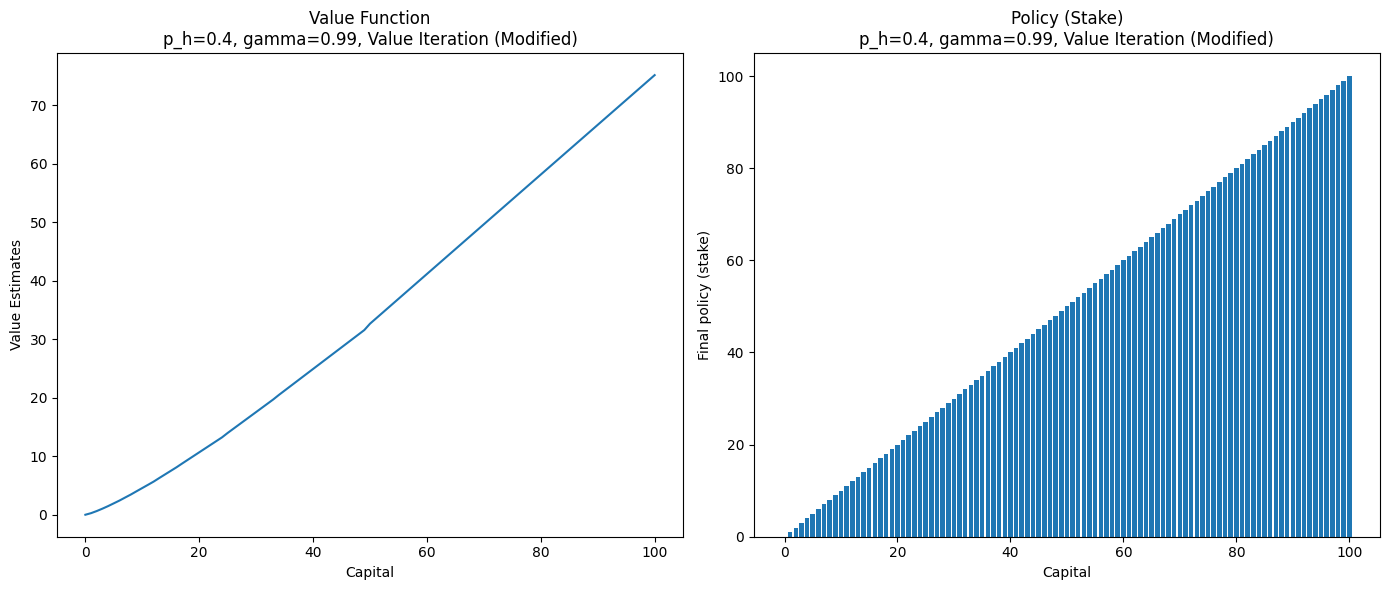

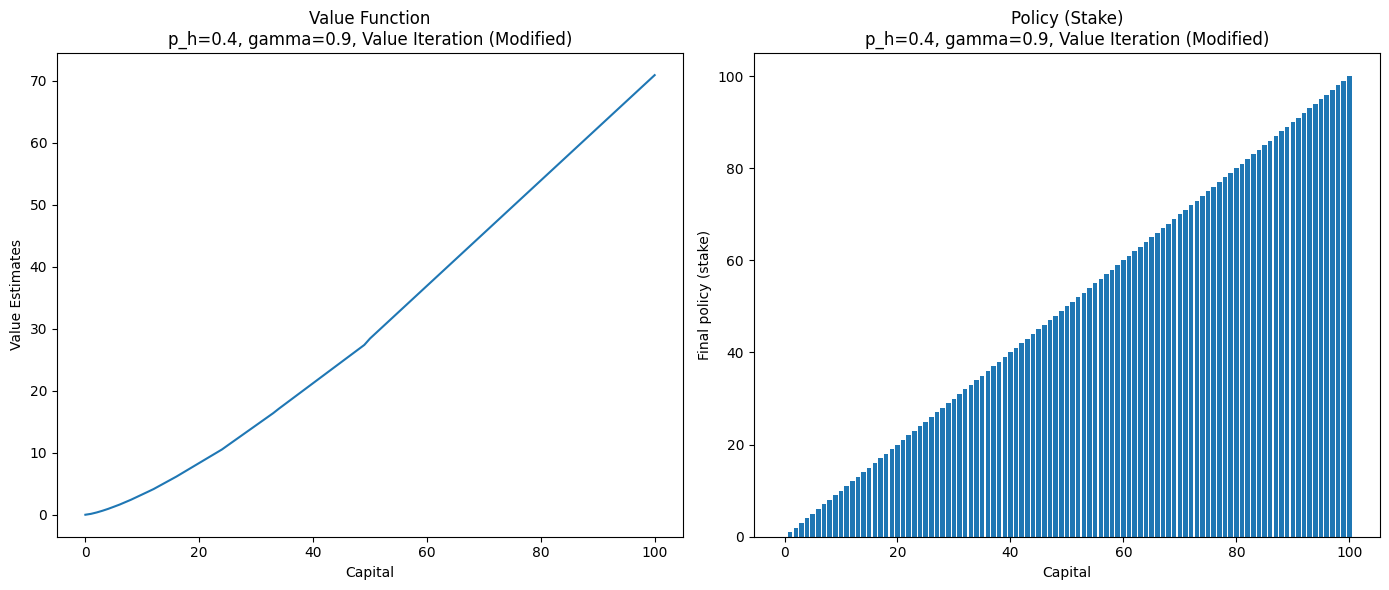

KeyboardInterrupt: 

In [60]:
run_modified_experiments(ph_values, gamma_values)


# Conclusion
As the probability of heads increases, the gambler's policy becomes capable of taking higher stakes. As discount factor gamma decreases the policy takes higher stakes for higher capital more often. It might be because the policy wants to earn rewards as early as possible. If we remove the limit on stakes as in task 2, the policy becomes linear, going all in, but when discount factor is 1, the policy wants to stay longer by playing small stake as it reaches winning value, in order for it to increase the chances of ending up winning more in the long run. But when the discount factor is less than one, the policy tries to get as much reward as possible in order to get the best in less time.
For task 1 the triangular nature of the policy pre-evidently shows how the policy is playing optimally in order for it win and not end up loosing too much.
While when the heads chances are high, the policy shows an interesting pattern for discount rate of 1. It just keeps the stake as 1 for more than 0 and less than 100 capital. As if it has become certain that the best way to make sure of winning is to keep the stakes as low as possible when odds are in our favour, that absolutly solidifies the odds of wining and saying long run to see the win happen.